# Проектная работа
# Рынок заведений общественного питания Москвы

## Введение

**Задача исследования:** В данной работе предстоит исследовать рынок общественного питания в городе Москва и найти интересные особенности, а также подготовить презентацию с основными тезисами. Приступим к работе

## Подготовка данных

### Импортируем необходимый набор библиотек для последующей работы над проектом

In [1]:
import pandas as pd
from io import BytesIO #Эта библиотека необходима вместе с 'requests' для доступа к файлу с данными из гугл диска
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter #для построения графиков
import warnings #чтобы не всплывали ненужные предупреждения
from scipy import stats as st #библиотека необходима для последующей проверки гипотез
from datetime import datetime, timedelta
from plotly import graph_objects as go
import plotly.express as px
# импортируем карту и хороплет
from folium import Map, Choropleth
# импортируем карту и маркер
from folium import Map, Marker
# импортируем кластер
from folium.plugins import MarkerCluster

In [2]:
pd.options.display.float_format = '{: .2f}'.format #отобразим данные с двумя числами после запятой

### Откроем файл с данными

In [3]:
#создадим датасет data
try:
    data = pd.read_csv('moscow_places.csv')
except: 
    spreadsheet_id = '1kgg8fFCUD2NFnWg3eLrv__HuRcUH76kNsHNQ7nR8Jfk'
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    data = pd.read_csv(BytesIO(r.content))

In [4]:
data.info()

### Вывод

<p></p>

<div style="border:solid black 1px; padding: 20px">

Открыли файл с данными и изучили типы столбцов. Проведем предобработку данных в следующем пункте
    
    
    
    
</div>

<p></p>

## Предобработка данных

### Посчитаем количество пропусков в датасетах

In [5]:
data.isna().sum()

In [6]:
data.hours.isna().sum() / len(data)

In [7]:
data = data.dropna(subset=['hours'])

In [8]:
percent = data.isna().sum()
percent / len(data)

### Проверим данные на наличие явных дубликатов в колонках, в которых они могут встречаться

In [9]:
data.name.duplicated().sum()

In [10]:
data.category.value_counts()

In [11]:
data.price.value_counts()

### Создадим столбец street с названиями улиц из столбца с адресом

In [12]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд','аллея','бульвар']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

data["street"] = data["address"].str.extract(str_pat)

data.street.head(5)

### Создадим столбец is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7):

In [13]:
data["is_24/7"] = data['hours'].str.contains(r'ежедневно, круглосуточно')
data["is_24/7"].value_counts()

### Вывод

<p></p>

<div style="border:solid black 1px; padding: 20px">

В ходе предобработки данных были удалены из данных пропуски из столбца hours, поскольку их незначительное количество около 6%, а остальные пропуски оставим. Дубликаты не были обнаружены. Были созданы столбцы sreet и is_24/7
    
    
    
</div>

<p></p>

## Анализ данных

### Какие категории заведений представлены в данных? Исследуйте количество объектов общественного питания по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Ответьте на вопрос о распределении заведений по категориям.

In [14]:
df = data.category.value_counts()

name_rest = df.index
values = df

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values)])
fig.update_layout(
    title_text="Количество объектов общественного питания по категориям",
)
fig.show()


### Исследуйте количество посадочных мест в местах по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Проанализируйте результаты и сделайте выводы.

In [15]:
seats = (data.groupby(['category'])
    .agg({'seats':'sum'})
    .sort_values(by='seats', ascending=False)
    .reset_index()
)

In [16]:
name_rest = seats.category
values = seats.seats

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values)])
fig.update_layout(
    title_text="Количество посадочных мест в объектов общественного питания по категориям",
)
fig.show()

### Рассмотрим и изобразим соотношение сетевых и несетевых заведений в датасете. Каких заведений больше?

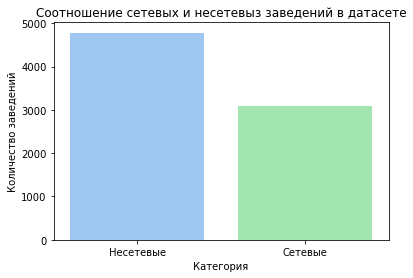

In [17]:
with plt.style.context('seaborn-pastel'):
    ax = sns.countplot(x = data.chain)
    plt.xlabel('Категория')
    plt.ylabel('Количество заведений')
    plt.title('Соотношение сетевых и несетевыз заведений в датасете')
    ax.set(xticklabels=['Несетевые', 'Сетевые'])

### Какие категории заведений чаще являются сетевыми? Исследуем данные и ответим на вопрос графиком.

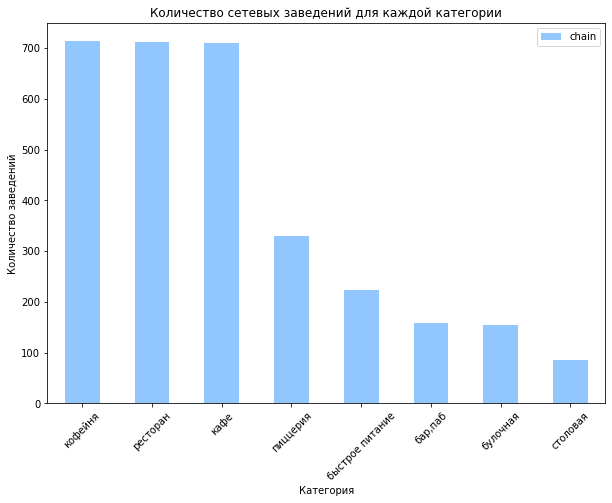

In [18]:
chain = (data.groupby(['category'])
    .agg({'chain':'sum'})
    .sort_values(by='chain', ascending=False)
    .reset_index()
)

with plt.style.context('seaborn-pastel'):
    ax = chain.plot(kind='bar', figsize=(10,7))
    ax.set(xticklabels = chain.category)
    plt.xticks(rotation = 45)
    plt.xlabel('Категория')
    plt.ylabel('Количество заведений')
    plt.title('Количество сетевых заведений для каждой категории')

### Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Под популярностью понимается количество заведений этой сети в регионе. Постройте подходящую для такой информации визуализацию. Знакомы ли вам эти сети? Есть ли какой-то признак, который их объединяет? К какой категории заведений они относятся?

In [19]:
name = data.name.value_counts().head(15)
name_rest = name.index
values = name

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values)])
fig.update_layout(
    title_text="Количество сетей общественного питания",
)
fig.show()

### Какие административные районы Москвы присутствуют в датасете? Отобразите общее количество заведений и количество заведений каждой категории по районам. Попробуйте проиллюстрировать эту информацию одним графиком.

In [20]:
district = (data.groupby(['district', 'category'],as_index=False)
            .agg(quantity=('category','count')).sort_values('quantity', ascending = False)
            .reset_index(drop=True)
)
district

In [21]:
fig = px.bar(district, x='district', y='quantity', color='category',
             title='Общее количество заведений и количество заведений каждой категории по районам', 
             labels={'category':'Тип заведений', 'quantity':'Общее количество заведений', 'district':'Район'})
fig.show()

### Визуализируйте распределение средних рейтингов по категориям заведений. Сильно ли различаются усреднённые рейтинги в разных типах общепита?

In [22]:
rating = (data.groupby(['category'])
    .agg({'rating':'mean'})
    .sort_values(by='rating', ascending=False)
    .reset_index()
)
rating

In [23]:
fig = px.bar(rating, y='rating', x='category', text='rating', color='rating', labels={'rating': 'рейтинг', 'category' : 'категория'})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title="Распределение средних рейтингов по категориям заведений",
    xaxis_title="Категория заведений",
    yaxis_title="Средний рейтинг",
    legend_title="Рейтинг"
)

fig.show()

### Постройте фоновую картограмму (хороплет) со средним рейтингом заведений каждого района. Границы районов Москвы, которые встречаются в датасете, хранятся в файле admin_level_geomap.geojson (скачать файл для локальной работы).

In [24]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=data,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='Purples',
    fill_opacity=0.8,
    legend_name='Средний рейтинг заведений по районам',
).add_to(m)

# выводим карту
m

### Отобразите все заведения датасета на карте с помощью кластеров средствами библиотеки folium.

In [25]:
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
data.apply(create_clusters, axis=1)

# выводим карту
m

### Найдите топ-15 улиц по количеству заведений. Постройте график распределения количества заведений и их категорий по этим улицам. Попробуйте проиллюстрировать эту информацию одним графиком.

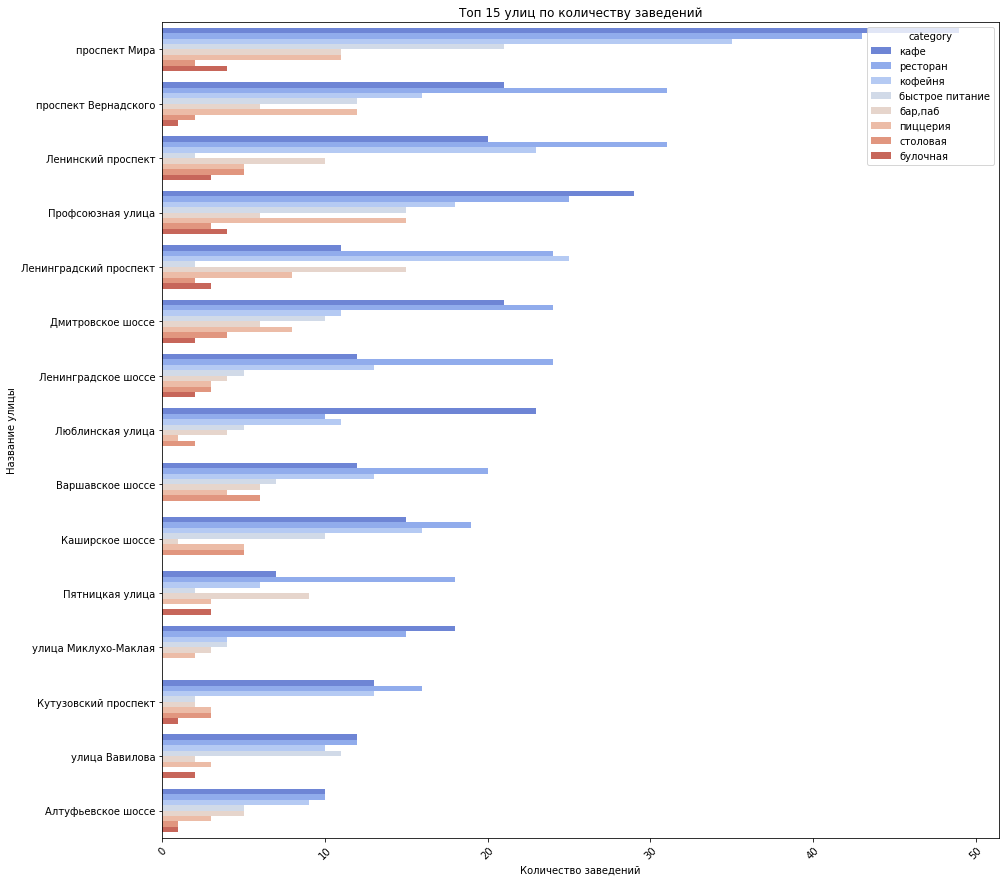

In [26]:
top_street = (data.groupby(['street'])['name']
                 .agg('count')
                 .sort_values(ascending=False)
                 .reset_index()
).head(15)

top_category = (data
                .query('street.isin(@top_street.street)')
                .groupby(['street', 'category'])['name']
                .agg('count')
                .sort_values(ascending=False)
                .reset_index()
)

plt.figure(figsize=(15,15))
sns.barplot(y='street', x='name', hue='category', data=top_category, palette = 'coolwarm')
plt.xticks(rotation=45)
plt.title('Топ 15 улиц по количеству заведений')
plt.xlabel('Количество заведений')
plt.ylabel('Название улицы')
plt.show()

### Найдите улицы, на которых находится только один объект общепита. Что можно сказать об этих заведениях?

In [27]:
#посчитаем количество улиц, на которых только один объект
street = (data.groupby(['street'],as_index=False)
            .agg(quantity=('category','count')).sort_values('quantity', ascending = False)
)
street = street[street['quantity']==1].reset_index(drop=True)
#объединим два датафрейма,для удобства построения карты
street = pd.merge(street, data,
                 how = 'left', on='street')
street.head(5)

In [28]:
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)


street.apply(create_clusters, axis=1)
m

### Значения средних чеков заведений хранятся в столбце middle_avg_bill. Эти числа показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном. Посчитайте медиану этого столбца для каждого района. Используйте это значение в качестве ценового индикатора района. Постройте фоновую картограмму (хороплет) с полученными значениями для каждого района. Проанализируйте цены в центральном административном округе и других. Как удалённость от центра влияет на цены в заведениях?

In [29]:
median = (data.groupby(['district'],as_index=False)
            .agg(median=('middle_avg_bill','median')).sort_values('median', ascending = False)
)
median

In [30]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=median,
    columns=['district', 'median'],
    key_on='feature.name',
    fill_color='Reds',
    fill_opacity=0.8,
    legend_name='Медианный чек в заведениях по районам',
).add_to(m)

# выводим карту
m

### Вывод

<p></p>

<div style="border:solid black 1px; padding: 20px">
В ходе анализа данных была получена информация:
    
- Большинство заведений в данных являются: рестораном, кафе, кофейней
- Несетевых заведений в данных больше, чем сетевых
- Чаще всего сетевыми являются кафе, ресторан, кофейня
- Наиболее популярными сетями являются: 'Шоколадница', 'Кафе', 'Домино'с Пицца'
- Самыми популярными административными районами Москвы по количеству заведений являются:
|Административный район|Топ 3 категории заведений|   |  
|---|---|---|
|Центральный административный округ   | Ресторан, кафе, кофейня   |  
|Западный административный округ   | Ресторан, кафе, кофейня  |  
|Южный административный округ   | Ресторан, кафе, кофейня  |   
- Средний рейтинг выше у баров (пабов), пиццерий, ресторанов, чем о остальных категорий
- Самыми популярными улицами по количеству заведений являются: проспект Мира, проспект Вернадского, Ленинский проспект
- Улицы, на которых находится только один объект общепита, находятся на расстоянии от главных дорог и обычно находятся в жилом секторе исходя из их расположения на карте
- Медианный чек является наиболее высоким в Западном, Центральном, Северо-Западном административных округах
    
    
    
    
</div>

<p></p>

## Детализируем исследование: открытие кофейни

### Сколько всего кофеен в датасете? В каких районах их больше всего, каковы особенности их расположения?

In [31]:
data.category.value_counts()

In [32]:
cafe = data[data['category'] == 'кафе'].reset_index(drop=True)
len(cafe)

In [33]:
cafe_quantity = (cafe.groupby(['district'],as_index=False)
            .agg(quantity=('category','count')).sort_values('quantity', ascending = False)
).reset_index(drop=True)
cafe_quantity

In [34]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=cafe_quantity,
    columns=['district', 'quantity'],
    key_on='feature.name',
    fill_color='Blues',
    fill_opacity=0.8,
    legend_name='Количество кофеен в районе',
).add_to(m)

# выводим карту
m

### Есть ли круглосуточные кофейни?

In [35]:
cafe['is_24/7'].value_counts()

In [36]:
267/len(cafe) * 100

### Какие у кофеен рейтинги? Как они распределяются по районам?

In [37]:
cafe.rating.describe()

In [38]:
rating_cafe = (cafe.groupby(['district'])
    .agg({'rating':'mean'})
    .sort_values(by='rating', ascending=False)
    .reset_index()
)


fig = px.bar(rating_cafe, y='rating', x='district', text='rating', color='rating', labels={'rating': 'рейтинг', 'category' : 'район'})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title="Распределение средних рейтингов кафе по районам",
    xaxis_title="Район",
    yaxis_title="Средний рейтинг",
    legend_title="Рейтинг"
)

fig.show()

In [39]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=rating_cafe,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='Greys',
    fill_opacity=0.8,
    legend_name='Средний рейтинг кофеен по районам',
).add_to(m)

# выводим карту
m

### На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?

In [40]:
data.middle_coffee_cup.describe()

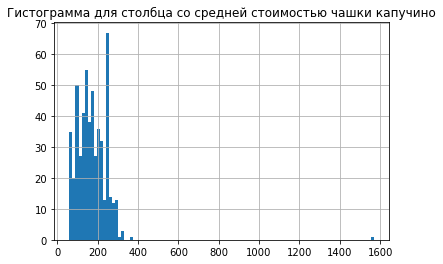

In [41]:
data.middle_coffee_cup.hist(bins=100)
plt.title('Гистограмма для столбца со средней стоимостью чашки капучино')
plt.show()

In [42]:
clean_data = data[data.middle_coffee_cup < 1400] #Уберем выброс мешающий анализу

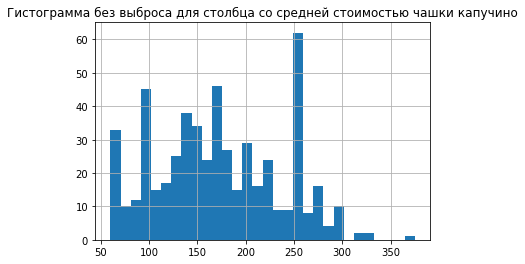

In [43]:
clean_data.middle_coffee_cup.hist(bins=30)
plt.title('Гистограмма без выброса для столбца со средней стоимостью чашки капучино')
plt.show()

In [44]:
clean_data.middle_coffee_cup.describe()

In [45]:
coffee_cup = (clean_data.groupby(['district'])
    .agg({'middle_coffee_cup':'mean'})
    .sort_values(by='middle_coffee_cup', ascending=False)
    .reset_index()
)
coffee_cup

In [46]:
# загружаем JSON-файл с границами округов Москвы
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=coffee_cup,
    columns=['district', 'middle_coffee_cup'],
    key_on='feature.name',
    fill_color='RdPu',
    fill_opacity=0.8,
    legend_name='Средняя цена кружки капучино',
).add_to(m)

# выводим карту
m

### Вывод

<p></p>

<div style="border:solid black 1px; padding: 20px">

Исходя из исследования по рынку кофеен в Москве:
- Всего в данных 2003 кофейни. Больше всего из них расположены в Центральном, Северо-Восточном, Восточном административных округах
- Круглосуточных кофеен примерно 13% от общего числа
- Средний рейтинг кофеен составляет 4.15. Наивысший средний рейтинг у кофеен в Центральном, Северном и Восточном административных округах
- Средняя стоимость чашки капучино 168 рублей и на нее стоит ориентироваться. Лидерами по средней цене чашки являются: Западный, Центральный и Юго-Западный административные округа

    
    
</div>

<p></p>

## Подготовка презентации

https://drive.google.com/file/d/18Rrhc6jGOKGJGSvn9Fpo8x8MFRi5h_bw/view?usp=sharing